In [1]:
import torch as tr
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch import nn
from torchvision.utils import make_grid as make_image_grid

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
import numpy as np

4) Variational autoencoder

Previously we discussed variational inferene with flow based models and applied it to a simple logistic regression model. Now we will apply this to real data using the concepts of variational autoencoders (VAE).

We will use MNIST data set for handwritten digits and want to create a generative model. So lets first investigate the dataset.

In [2]:
trainloader = DataLoader(
    MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=256,shuffle=True)
testloader = DataLoader(
    MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=256,shuffle=True)

In [3]:
input_shape = testloader.dataset.data[0].shape
print(input_shape)

torch.Size([28, 28])


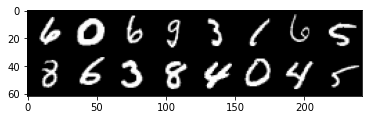

In [4]:
images,_ = iter(testloader).next()
images = images[:16]
plt.imshow(np.transpose(make_image_grid(images).numpy(), (1,2,0)))

The generative model with parameters $\theta$ is
\begin{align}
p_\theta(\mathbf{z}, \mathbf{x}) = p_\theta(\mathbf{x}|\mathbf{z}) p(\mathbf{z}) \qquad  p_\theta(\mathbf{x}|\mathbf{z})=\mathcal{N}\Big(\mu_\theta(\mathbf{z}), \sigma^2\mathbf{I} \Big) \qquad  p(\mathbf{z}) = \mathcal{N}\Big(\mathbf{0}, \mathbf{I}\Big)
\end{align}

Our approximation to the posterior $p(\mathbf{z}|\mathbf{x})$ is of the form
\begin{align}
p(\mathbf{z}|\mathbf{x}) \approx q_\phi(\mathbf{z}|\mathbf{x})=\mathcal{N}\Big(\mu_\phi(\mathbf{x}),\Sigma_\phi(\mathbf{x})\Big),
\end{align}
where

- $\mu_\phi(\mathbf{x})$ --> Given by a Neural Network with parameter vector $\phi$ and input $\mathbf{x}$

- $\Sigma_\phi(\mathbf{x})$ --> Diagonal covariance matrix, where the log of the main diagonal is constructed by a Neural Network with parameter vector $\phi$ and input $\mathbf{X}$

- $\sigma$ is a hyperparamter that controls the reconstruction noise. Small values for $\sigma$ punish reconstruction error larger, hence we set $\sigma = 0.1$.


In [235]:
class VAE(nn.Module):
    def __init__(self,input_shape, latent_dim=20,hidden_dim=500):
        super(VAE,self).__init__()
        self.input_shape = input_shape
        self.input_dim = int(input_shape[0]*input_shape[1])
        self.fc_e = nn.Sequential(nn.Linear(self.input_dim,hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU())
        self.fc_mean = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        self.fc_d = nn.Sequential(nn.Linear(latent_dim,hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim,self.input_dim),
                                  nn.Sigmoid())
            
    def encoder(self,x_in):
        x = self.fc_e(x_in.view(-1,self.input_dim))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar
    
    def decoder(self,z):
        x_out = self.fc_d(z)
        return x_out.view(-1,1,*self.input_shape)
    
    def sample_normal(self,mean,logvar):
        sd = tr.exp(logvar*0.5)
        e = tr.tensor(tr.randn(sd.size()))
        z = e.mul(sd).add_(mean)
        return z
    
    def forward(self,x_in):
        z_mean, z_logvar = self.encoder(x_in)
        z = self.sample_normal(z_mean,z_logvar)
        x_out = self.decoder(z)
        return x_out, z_mean, z_logvar

model = VAE(input_shape, latent_dim=2,hidden_dim=512)

We want to optimize the ELBO. The ELBO for a single data sample $x$ is given by:
$$ \mathcal{L}(x, \theta, \phi) = \mathbb{E}_q[\log p_\theta(x|z)] - D_{KL}(q_\phi (z|x) || p(z))$$
where the the KL divergence term is known in closed form since it is the KL divergence between two Gausian pdfs:
$$ D_{KL}(q_\phi(z|x) || p(z)) = \frac{1}{2} [tr(\Sigma(x)) + (\mu(x)^T \mu(x)) - 2 - \log \det(\Sigma(x))]$$
As we assume a diagonal covariance, the determinant is just equal the sum of the diagonal values, hene we can compute this on O(d).
The first time is just the loglikelihood of our model, which is given by 
    $$ \log p_\theta(x|z) = \log \mathcal{N}(x; \mu_\theta(z), \sigma^2 I) = d*\log 2\pi - d/2*\log(\sigma) -\frac{1}{2}\sum_{i=1}^d \frac{(\mu_\theta(z)_i - x_i)^2}{\sigma^2}$$

In [68]:
def nll_gauss(mean, std, x, axis=None):
    """Gaussian log likelihood"""
    var = std**2
    const = tr.log(tr.tensor(2*np.pi))*tr.ones(x.shape)
    ll = const - 0.5*tr.log(var) - 0.5*tr.div((mean-x)**2,var)
    return -tr.sum(ll) if axis is None else -tr.sum(ll, axis=axis) 
def elbo(x, z_mu, z_logvar, out_mean, sigma=0.1,beta=1.0):
    out_std = tr.ones_like(out_mean) *sigma
    elbo_KL = beta*(-0.5*tr.sum(1+ z_logvar - (z_mu**2) - tr.exp(z_logvar)))
    elbo_nll = nll_gauss(out_mean, out_std, x)
    return (elbo_nll + elbo_KL)/x.size(0)

In [186]:
optimizer = optim.Adam(model.parameters())
epochs = 16
elbo_list = []
for epoch in range(epochs):
    for images,_ in trainloader:
        x_in = images
        optimizer.zero_grad()
        x_out_mean, z_mu, z_logvar = model(x_in)
        loss = elbo(x_in, z_mu, z_logvar, x_out_mean)
        loss.backward() 
        optimizer.step()
        elbo_list.append(loss.detach().numpy())

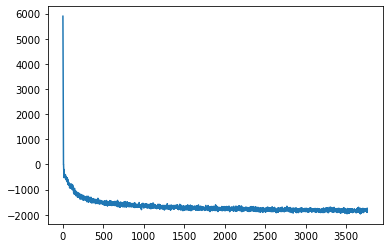

In [187]:
plt.plot(elbo_list)

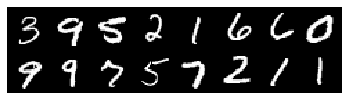

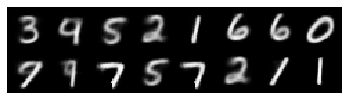

In [188]:
def visualize_mnist_vae(model,dataloader,num=16):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = tr.tensor(images)
    x_out,*params = model(x_in)
    x_out = x_out.data.cpu()
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

visualize_mnist_vae(model,testloader)

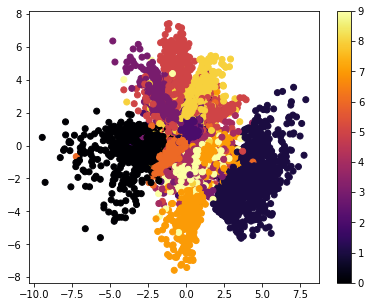

In [189]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,*params = model.encoder(images)
        z_means_x = np.append(z_means_x,z_means[:,0].data.cpu().numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.cpu().numpy())
        all_labels = np.append(all_labels,labels.cpu().numpy())
        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(model,testloader)

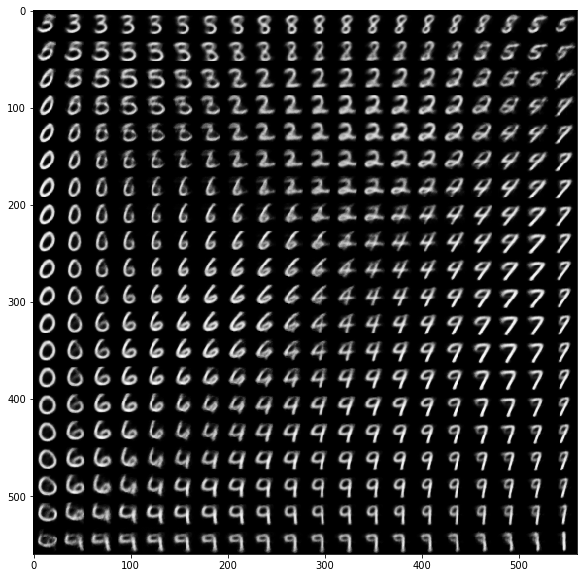

In [190]:
# Visualize digits generated from latent space grid
from scipy.stats import norm
def visualize_decoder(model,num=20,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = tr.FloatTensor([[x,y]])
            image = model.decoder(z)
            image = image.data.cpu().numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid, cmap='gray')
    plt.show()

visualize_decoder(model, num=20)

That looks rater nice. However we learly se several limitations. First the rather blury reconstructions which origin is debatable with several proposed explanation e.g. using elbo as loss (expecation), the KL regularizer to a simplistic standard normal distribution or the use of a simplisti latent posterior distribution (Gaussian).

The blurry reconstructions can be mitigates by using more powerfull decoders; however, then the latent representation becomes useless as the decoder does "all the work".

We can use **normalizing flows** to solve some of these problems, especially we can use more powerful variational distributions while still be able to compute the elbo.

## 2) Normalizing flows and VAEs

One of the main limitations of VAEs is that they rely on simple family of approximations e.g. a Gaussian one. We can use normalizing flows to complexify the posterior distribution.

We keep the generative model with parameters $\theta$ as
$$
\begin{align}
p_\theta(\mathbf{z}, \mathbf{x}) = p_\theta(\mathbf{x}|\mathbf{z}) p(\mathbf{z}) \qquad  p_\theta(\mathbf{x}|\mathbf{z})=\mathcal{N}\Big(\mu_\theta(\mathbf{z}), \sigma^2\mathbf{I} \Big) \qquad  p(\mathbf{z}) = \mathcal{N}\Big(\mathbf{0}, \mathbf{I}\Big)
\end{align}
$$

However we will use a flow based model as variational posterior.

In [667]:
class Flow(transform.Transform, nn.Module):
    """ Abstract Flow class: Importas module to be able to train paramters properly """
    def __init__(self, *args, **kwargs):
        super().__init__(*args,**kwargs)
        super(nn.Module, self).__init__()
    
    def init_parameters(self):
        """ Initialization of paramters """
        for param in self.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    # Hacky hash bypass (for optimization this is needed)
    def __hash__(self):
        return super(nn.Module,self).__hash__()

class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = []
        self.scale = []
        self.bias = []
        self.dim = dim

    def _call(self, z):
        z = z.unsqueeze(2)
        f_z = tr.bmm(self.weight, z) + self.bias
        return (z + self.scale * tr.tanh(f_z)).squeeze(2)

    def log_abs_det_jacobian(self, z):
        z = z.unsqueeze(2)
        f_z = tr.bmm(self.weight, z) + self.bias
        psi = self.weight * (1 - tr.tanh(f_z) ** 2)
        det_grad = 1 + tr.bmm(psi, self.scale)
        return tr.log(det_grad.abs() + 1e-9)
    
    def set_parameters(self, p_list):
        self.weight = p_list[:, :self.dim].unsqueeze(1)
        self.scale = p_list[:, self.dim:self.dim*2].unsqueeze(2)
        self.bias = p_list[:, self.dim*2].unsqueeze(1).unsqueeze(2)
        
    def n_parameters(self):
        return 2 * self.dim + 1

In [381]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        self.n_params = []
        for f in range(flow_length):
            for b_flow in blocks:
                cur_block = b_flow(dim)
                biject.append(cur_block)
                self.n_params.append(cur_block.n_parameters())
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []
        self.dim = dim

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
        
    def n_parameters(self):
        return sum(self.n_params)
    
    def set_parameters(self, params):
        param_list = params.split(self.n_params, dim = 1)
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.bijectors[b].set_parameters(param_list[b])

In [710]:
class VAEFlows(VAE):
    def __init__(self,input_shape, flows, latent_dim=20,hidden_dim=500):
        super().__init__(input_shape, latent_dim=latent_dim, hidden_dim=hidden_dim)
        self.fc_flow = nn.Linear(hidden_dim, flows.n_parameters())
        self.flows = flows

    def encoder(self,x_in):
        x = self.fc_e(x_in.view(-1,self.input_dim))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        flow_params = self.fc_flow(x)
        return mean, logvar, flow_params

    def forward(self,x_in):
        z_mean, z_logvar, flow_params = self.encoder(x_in)
        self.flows.set_parameters(flow_params)
        z_0 = self.sample_normal(z_mean,z_logvar)
        z_K, log_dets = self.flows(z_0)
        x_out = self.decoder(z_K)
        return x_out, z_0, z_K, z_mean, z_logvar, log_dets

In [711]:
block_planar = [PlanarFlow]
flow = NormalizingFlow(dim=2, blocks=block_planar, flow_length=16,density=distrib.MultivariateNormal(tr.zeros(2), tr.eye(2)))

In [712]:
model2 = VAEFlows((28,28), flow, latent_dim=2, hidden_dim=512)

However the approximation to the posterior $p(\mathbf{z}|\mathbf{x})$ is of the form $q_\phi(z|x)$ which is a flow base model given by 
$$ q_\phi(z|x) = q_K(z_K) = q_0(z_0) \cdot \prod_{k=1}^K \log|\det \frac{\partial f_k}{\partial z_{k-1}}$$
We will use $q_0(z_0) = \mathcal{N}(\mu(x), \Sigma(x))$ and will optimize both $\psi = \{\mu, \Sigma\}$ and the paramters of the flow $\phi$. The Elbo is given by 
$$ \mathcal{L}(x, \theta, \psi, \phi) = \mathbb{E}_{q_\phi}[\log q_{\phi,\psi}(z|x) - \log p(x,z)] = \mathbb{E}_{q_0}[\log q_0(z_0)] - \mathbb{E}_{q_0} [\log p(x,z_K)] - \mathbb{E}_{q_0}\left[\sum_{k=1}^K \log \left| \det \frac{\partial f_k}{\partial z_{k-1}} \right|\right] $$

In [713]:
def nll_gauss(mean, std, x, axis=None):
    """Gaussian log likelihood"""
    var = std**2
    const = tr.log(tr.tensor(2*np.pi))*tr.ones(x.shape)
    ll = const - 0.5*tr.log(var) - 0.5*tr.div((mean-x)**2,var)
    return -tr.sum(ll) if axis is None else -tr.sum(ll, axis=axis) 
def elbo(x,z_0,z_K, z_mu, z_logvar, out_mean, log_dets,sigma=1):
    out_std = tr.ones_like(out_mean) *sigma
    elbo_nll = nll_gauss(out_mean, out_std, x)
    elbo_p_z_K = -0.5*z_K*z_K
    elbo_q_z_0 = -0.5*(z_mu - z_0)**2/(tr.exp(z_logvar)) - 0.5*z_logvar
    logs = (elbo_q_z_0 - elbo_p_z_K).sum()
    logs -= tr.cat(log_dets).sum()

    return (elbo_nll + logs)/x.size(0)

In [714]:
optimizer = optim.Adam(model2.parameters())
epochs = 16
elbo_list = []
for epoch in range(epochs):
    for images,_ in trainloader:
        x_in = images
        optimizer.zero_grad()
        x_out_mean, z_0, z_K, z_mu, z_logvar, log_dets = model2(x_in)
        loss = elbo(x_in, z_0, z_K, z_mu, z_logvar, x_out_mean, log_dets)
        loss.backward() 
        optimizer.step()
        elbo_list.append(loss.detach().numpy())

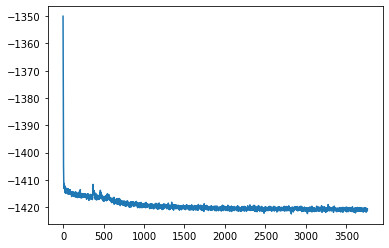

In [715]:
plt.plot(elbo_list)

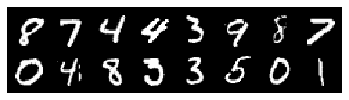

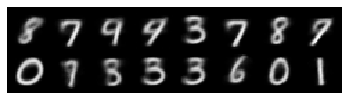

In [716]:
def visualize_mnist_vae(model,dataloader,num=16):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = tr.tensor(images)
    x_out, *rest = model(x_in)
    x_out = x_out.data.cpu()
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

visualize_mnist_vae(model2,testloader)

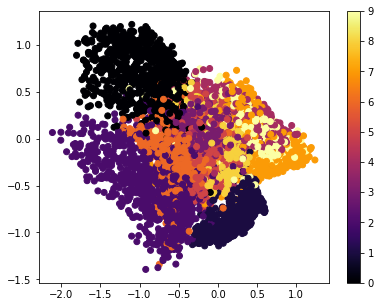

In [717]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,*rest = model.encoder(images)
        z_means_x = np.append(z_means_x,z_means[:,0].data.cpu().numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.cpu().numpy())
        all_labels = np.append(all_labels,labels.cpu().numpy())
        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(model2,testloader)

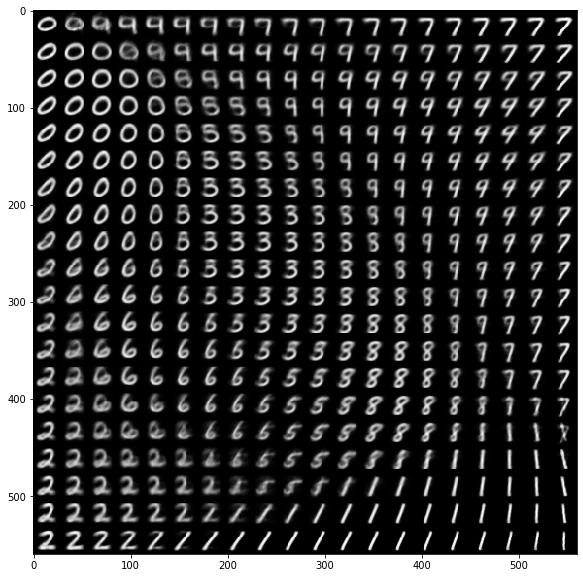

In [718]:
visualize_decoder(model2, num=20)

That looks rather great! But lets also visulice the posterior of z.

## 3) Conditional Variational Encoders (CVAEs)

We've seen that VAE can serve as good generative model. Further its latent space leads by construction to a "clustering" of the data. One problem is that we do not have controll over the data generation problem. For example it is hard to say: We want to generate only the number five!

Thus conditional Variational Auto Encoders were create, which model latent variables and data both conditioned to some random variable. Lets consider MNIST. Be $y$ the label of that data, that is $y$ is a binary vector of length ten, which indicate what digit is on the image $x$. In contrast to VAE which want to learn $p(x)$, we now want to learn the conditional distribution $p(x|y)$. Hence the ELBO becomes
$$ \mathcal{L}(x, \theta, \phi) = \mathbb{E}_q[\log p_\theta(x|z,y)] - D_{KL}(q_\phi (z|x,y) || p(z|y))$$
For simplicity we will choose $p(z|y) = \mathcal{N}(0,I)$.

In [85]:
class CVAE(nn.Module):
    def __init__(self,input_shape, num_classes, latent_dim=20,hidden_dim=500):
        super(CVAE,self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.input_dim = int(input_shape[0]*input_shape[1]) 
        self.fc_e = nn.Sequential(nn.Linear(self.input_dim+num_classes,hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU())
        self.fc_mean = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        self.fc_d = nn.Sequential(nn.Linear(latent_dim + num_classes,hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim,self.input_dim),
                                  nn.Sigmoid())
            
    def encoder(self,x_in, y):
        y = tr.eye(self.num_classes)[y]
        x = x_in.view(-1,self.input_dim)
        x = tr.hstack((x,y))
        h = self.fc_e(x)
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar
    
    def decoder(self,z,y):
        y = tr.eye(self.num_classes)[y]
        z = tr.hstack((z,y))
        x_out = self.fc_d(z)
        return x_out.view(-1,1,*self.input_shape)
    
    def sample_normal(self,mean,logvar):
        sd = tr.exp(logvar*0.5)
        e = tr.tensor(tr.randn(sd.size()))
        z = e.mul(sd).add_(mean)
        return z
    
    def forward(self,x_in,y):
        z_mean, z_logvar = self.encoder(x_in,y)
        z = self.sample_normal(z_mean,z_logvar)
        x_out = self.decoder(z,y)
        return x_out, z_mean, z_logvar
model = CVAE(input_shape,10, latent_dim=2,hidden_dim=512)

In [86]:
optimizer = optim.Adam(model.parameters())
epochs = 16
elbo_list = []
for epoch in range(epochs):
    for images,y in trainloader:
        x_in = images
        optimizer.zero_grad()
        x_out_mean, z_mu, z_logvar = model(x_in,y)
        loss = elbo(x_in, z_mu, z_logvar, x_out_mean)
        loss.backward() 
        optimizer.step()
        elbo_list.append(loss.detach().numpy())

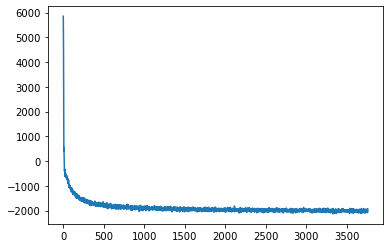

In [87]:
plt.plot(elbo_list)

Lets visulize the learned manifold for CVAE

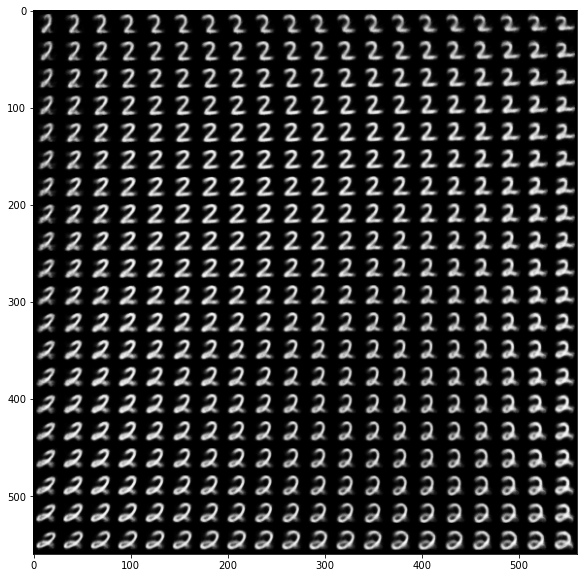

In [146]:
from scipy.stats import norm
def visualize_decoder(model, number,num=20,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = tr.FloatTensor([[x,y]])
            image = model.decoder(z, tr.tensor([number]))
            image = image.data.cpu().numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid, cmap='gray')
    plt.show()
visualize_decoder(model, 2)

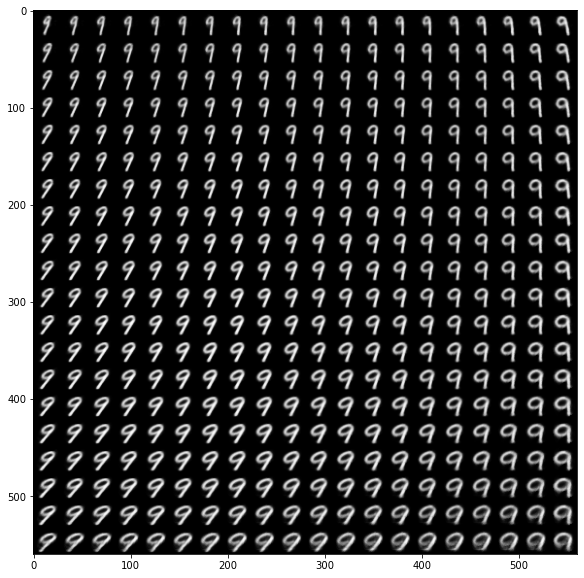

In [147]:
visualize_decoder(model, 9)

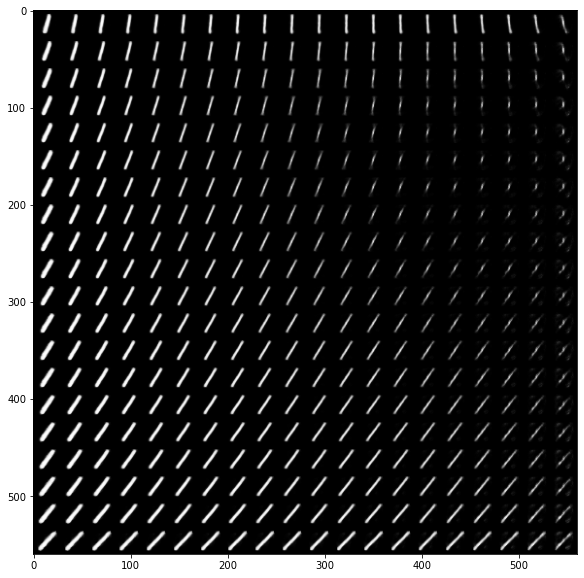

In [156]:
visualize_decoder(model, 1)

That looks nice! Lets come to the "downsite" of this implementation. Lets consider the latent space.

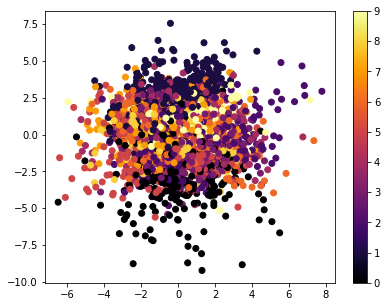

In [157]:
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,*params = model.encoder(images, labels)
        z_means_x = np.append(z_means_x,z_means[:,0].data.cpu().numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.cpu().numpy())
        all_labels = np.append(all_labels,labels.cpu().numpy())
        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(model,testloader)

This looks messy! However this is by definition, as we choose that each conditional density $p(z|y) \sim \mathcal{N}(0,I)$ we observe exactly this. This model just does not need a good latent structure over the classes, as the classes are known we conditon on them!

## Sources:
* Kingma, D. P., & Welling, M. (2019). An introduction to variational autoencoders. arXiv preprint arXiv:1906.02691.
* Blei, D. M., Kucukelbir, A., & McAuliffe, J. D. (2017). Variational inference: A review for statisticians. Journal of the American statistical Association, 112(518), 859-877.
* Rezende, D., & Mohamed, S. (2015, June). Variational inference with normalizing flows. In International Conference on Machine Learning (pp. 1530-1538). PMLR.
* Papamakarios, G., Nalisnick, E., Rezende, D. J., Mohamed, S., & Lakshminarayanan, B. (2019). Normalizing flows for probabilistic modeling and inference. arXiv preprint arXiv:1912.02762.

Normalizing flow VAE inspired by https://github.com/acids-ircam/pytorch_flows